In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D , MaxPool2D , Dense , Flatten , InputLayer , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy

## DATA PREPARATION

#### Data Loading

In [ ]:
dataset , dataset_info = tfds.load("malaria", with_info = True , as_supervised = True , shuffle_files = True , split = ["train"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
dataset

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmphx1w965etfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


#### Splitting dataset into train , validation and test dataset

In [5]:
def splits(dataset, TRAIN_RATIO , VAL_RATIO , TEST_RATIO):
     DATASET_SIZE =  len(dataset)

     train_dataset =  dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

     val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
     val_dataset =  val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

     test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
     return train_dataset , val_dataset , test_dataset

In [6]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset , val_dataset , test_dataset = splits( dataset[0] , TRAIN_RATIO , VAL_RATIO, TEST_RATIO)
# print(list(train_dataset.take(1).as_numpy_iterator()) , list(val_dataset.take(1).as_numpy_iterator()) , list(test_dataset.take(1).as_numpy_iterator()))

## DATA VISUALIZATION

In [7]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

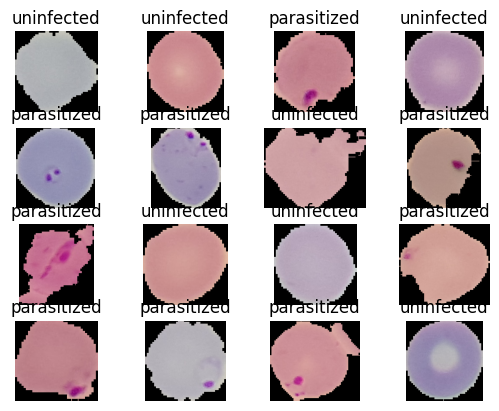

In [8]:
for i, (image,label) in enumerate(dataset[0].take(16)):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis("off")

In [9]:
# label 0 corresponds to paratsitized
# label 1 corresponds to uninfected
dataset_info.features["label"].int2str(0) , dataset_info.features["label"].int2str(1)

('parasitized', 'uninfected')

## DATA PREPROCESSING

In [10]:
IM_SIZE = 224
def resize_rescale(image , label):
  return (tf.image.resize(image , (IM_SIZE, IM_SIZE))/255.0) , label

In [11]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [12]:
for image,label in train_dataset.take(1):
  print(image)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32)


In [13]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8 , reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8 , reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## MODEL CREATION

In [14]:
lenet_model = tf.keras.Sequential([
                                InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),

                                Conv2D(filters=6, kernel_size=3,strides=1, padding='valid',activation = "relu"),
                                BatchNormalization(),
                                MaxPool2D(pool_size=(2, 2), strides=2),

                                Conv2D(filters=16, kernel_size=3 ,strides=1, padding='valid',activation = "relu"),
                                BatchNormalization(),
                                MaxPool2D(pool_size=(2, 2), strides=2),

                                Flatten(),

                                Dense(100, activation = "relu"),
                                BatchNormalization(),

                                Dense(10, activation = "relu"),
                                BatchNormalization(),

                                Dense(1, activation = "sigmoid"),
])
lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [15]:
lenet_model.compile(
    optimizer = Adam(learning_rate = 0.1),
    loss = BinaryCrossentropy(),
    metrics = ["accuracy"]
)

In [16]:
history = lenet_model.fit(train_dataset , validation_data = val_dataset, epochs=20, verbose =1)

Epoch 1/20
689/689 [==============================] - 774s 1s/step - loss: 0.5319 - accuracy: 0.7320 - val_loss: 0.9326 - val_accuracy: 0.8483
Epoch 2/20
689/689 [==============================] - 763s 1s/step - loss: 0.2717 - accuracy: 0.9119 - val_loss: 0.4164 - val_accuracy: 0.9267
Epoch 3/20
689/689 [==============================] - 763s 1s/step - loss: 0.2457 - accuracy: 0.9211 - val_loss: 1.3563 - val_accuracy: 0.5009
Epoch 4/20
689/689 [==============================] - 760s 1s/step - loss: 0.2273 - accuracy: 0.9283 - val_loss: 0.4606 - val_accuracy: 0.9060
Epoch 5/20
689/689 [==============================] - 754s 1s/step - loss: 0.1898 - accuracy: 0.9393 - val_loss: 1.1376 - val_accuracy: 0.9339
Epoch 6/20
689/689 [==============================] - 799s 1s/step - loss: 0.1691 - accuracy: 0.9470 - val_loss: 0.1722 - val_accuracy: 0.9448
Epoch 7/20
689/689 [==============================] - 808s 1s/step - loss: 0.1588 - accuracy: 0.9495 - val_loss: 0.8974 - val_accuracy: 0.9064

In [34]:
import json

history_dict = history.history
history_path = "/content/training_history.txt"
with open(history_path, "w") as f:
    json.dump(history_dict, f)
files.download(history_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

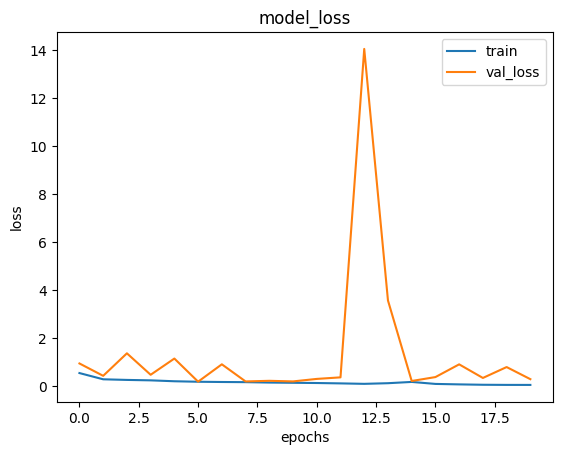

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train' , 'val_loss'])
plt.show()

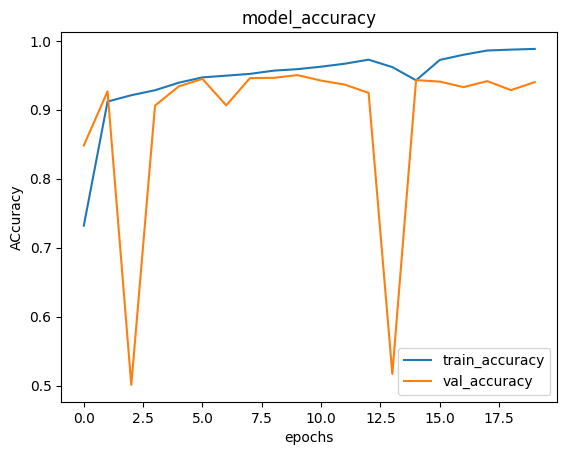

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('ACcuracy')
plt.xlabel('epochs')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

## MODEL EVALUATION

In [20]:
test_dataset = test_dataset.batch(1)

In [23]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 66s 18ms/step - loss: 0.2810 - accuracy: 0.9329


[0.28102508187294006, 0.9328981041908264]

In [24]:
lenet_model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 14s 14s/step


4.828616e-08

In [25]:
for image,label in test_dataset.take(1):
  print(label)

tf.Tensor([1], shape=(1,), dtype=int64)


In [26]:
def parasite_or_not(x) :
  if(x<0.5):
    return str("P")
  else :
    return str("U")

1/1 [==============================] - 0s 33ms/step


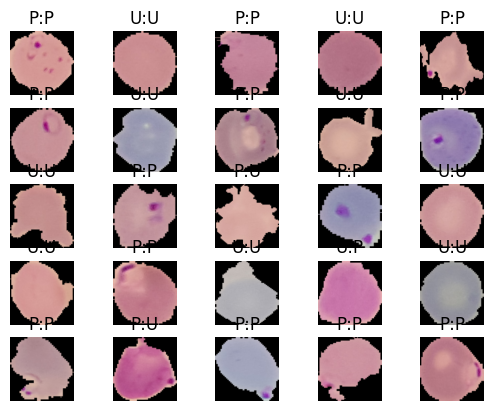

In [28]:
# plot of actual label and predicted label
for i , (image,label) in enumerate(test_dataset.take(25)):
  ax = plt.subplot(5,5,i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0]))+ ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))
  plt.axis("off")

In [31]:
from google.colab import files
model_path = "/content/lenet_save_model.h5"
lenet_save_model =  lenet_model.save(model_path)
files.download(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
import os
weights_dir = "/content/model_weights"
weights_path = os.path.join(weights_dir, "lenet_weights.h5")
os.makedirs(weights_dir, exist_ok=True)
lenet_model.save_weights(weights_path)
files.download(weights_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>